# <center> <font style="color:rgb(100,109,254)">   Creating  a Virtual Drum </font> </center>

In this notebook we will make another cool application, this time we will play drums virtually meaning we will hit non existent drums in the air and it will play their respective sounds. 

The steps to produce this application are:

1. *Find the color range of the target object and save it.*
2. *Apply the correct morphological operations to reduce noise.*
3. *Detect and track the object with contour detection.*
4. *Extract ROI's of Instruments.*
5. *Loading file names for sounds.*
6. *Playing the virtual drum with a single stick.*
7. *Making this work for two sticks, by adding the padding logic.*

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## <font style="color:rgb(134,19,348)">  Finding Color range of target Drum sticks and saving it  </font>

First and foremost we must find an appropriate color range for our target colored object , this range will be used in cv2.inrange() function to filter our object. We will also save our range array as .npy in our disk so we can access it later. Below function is the same as we have used in our color models notebook

In [67]:
def nothing(x):
    pass
 
cap = cv2.VideoCapture(2,cv2.CAP_DSHOW)
cap.set(3,1280)
cap.set(4,720)


cv2.namedWindow("Trackbars")
 
cv2.createTrackbar("L - H", "Trackbars", 0, 179, nothing)
cv2.createTrackbar("L - S", "Trackbars", 0, 255, nothing)
cv2.createTrackbar("L - V", "Trackbars", 0, 255, nothing)
cv2.createTrackbar("U - H", "Trackbars", 179, 179, nothing)
cv2.createTrackbar("U - S", "Trackbars", 255, 255, nothing)
cv2.createTrackbar("U - V", "Trackbars", 255, 255, nothing)
 
 
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip( frame, 1 ) 

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
 
    l_h = cv2.getTrackbarPos("L - H", "Trackbars")
    l_s = cv2.getTrackbarPos("L - S", "Trackbars")
    l_v = cv2.getTrackbarPos("L - V", "Trackbars")
    u_h = cv2.getTrackbarPos("U - H", "Trackbars")
    u_s = cv2.getTrackbarPos("U - S", "Trackbars")
    u_v = cv2.getTrackbarPos("U - V", "Trackbars")
 
    # set the lower and upper range according to the value selected by the trackbar.
    lower_range = np.array([l_h, l_s, l_v])
    upper_range = np.array([u_h, u_s, u_v])
    
    # filter and get the binary mask, where white represents your target color.
    mask = cv2.inRange(hsv, lower_range, upper_range)
 
    # optionally you can also show the real part of the target color
    res = cv2.bitwise_and(frame, frame, mask=mask)
    
    mask_3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # stack all frames and show it
    stacked = np.hstack((mask_3,frame,res))
    cv2.imshow('Trackbars',cv2.resize(stacked,None,fx=0.4,fy=0.4))
 
    key = cv2.waitKey(1)
    if key == 27:
        break
        
    if key == ord('s'):
        thearray = [[l_h,l_s,l_v],[u_h, u_s, u_v]]
        print(thearray)
        
        # Also save this array as drum.npy
        np.save('media/m12/drumval',thearray)
        break
    
cap.release()
cv2.destroyAllWindows()

[[141, 156, 131], [179, 255, 255]]


## <font style="color:rgb(134,19,348)">  Maximizing the Detection Mask and Getting rid of the noise  </font>
Now you may have noticed that there is some noise in the above program, this can easily be removed by morphological operations.

In [68]:
# This variable determines if we want to load color range from memory or use the ones defined in notebook. 
useload = True

# If true then load color range from memory
if useload:
    drumval = np.load('media/m12/drumval.npy')

cap = cv2.VideoCapture(2)

# kernel for morphological operations
kernel = np.ones((5,5),np.uint8)

while(1):
    
    # Take each frame and flip it
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip( frame, 1 )

    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # If you're reading from memory then load the upper and lower ranges from there
    if useload:
            lower_range = drumval[0]
            upper_range = drumval[1]
            
    # Otherwise define your own custom values for upper and lower range.
    else:             
       lower_range  = np.array([150,70,173])
       upper_range = np.array([179,189,255])
    
    mask = cv2.inRange(hsv, lower_range, upper_range)
    
    # perform the morphological operations to get rid of the noise
    mask = cv2.erode(mask,kernel,iterations = 1)
    mask = cv2.dilate(mask,kernel,iterations = 2)

   
    res = cv2.bitwise_and(frame,frame, mask= mask)

    mask_3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # stack all frames and show it
    stacked = np.hstack((mask_3,frame,res))
    cv2.imshow('Trackbars',cv2.resize(stacked,None,fx=0.8,fy=0.8))
    
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()
cap.release()

## <font style="color:rgb(134,19,348)">Tracking The Target Drum Sticks   </font>
Now that we have got a decent mask we can use it detect our drum sticks using contour detection, in fact we will draw a bonding box around it.

In [72]:
# This variable determines if we want to load color range from memory or use the ones defined in notebook. 
useload = True

# If true then load color range from memory
if useload:
    penval = np.load('media/m12/drumval.npy')

cap = cv2.VideoCapture(2)

# kernel for morphological operations
kernel = np.ones((5,5),np.uint8)

# set the window to autosize so we can view this full screen.
cv2.namedWindow('image', cv2.WINDOW_NORMAL)

# this threshold is used to filter noise, the contour area must be bigger than this to qualify as an actual contour.
noiseth = 500

while(1):
    
    # Take each frame and flip it
    _, frame = cap.read()
    frame = cv2.flip( frame, 1 )

    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # If you're reading from memory then load the upper and lower ranges from there
    if useload:
            lower_range = penval[0]
            upper_range = penval[1]
            
    # Otherwise define your own custom values for upper and lower range.
    else:             
       lower_range  =  np.array([150,70,173])
       upper_range =  np.array([179,189,255])
    
    mask = cv2.inRange(hsv, lower_range, upper_range)
    
    # perform the morphological operations to get rid of the noise
    mask = cv2.erode(mask,kernel,iterations = 1)
    mask = cv2.dilate(mask,kernel,iterations = 2)
    
    # detect contour.
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # Make sure there was a contour present and also its size was bigger than some threshold.
    if contours and cv2.contourArea(max(contours, key = cv2.contourArea)) > noiseth:
        
        # grab the biggest contour
        c = max(contours, key = cv2.contourArea)
        
        # Draw a bounding box around it.
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)        

    cv2.imshow('image',frame)
    
    k = cv2.waitKey(5) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()
cap.release()

##  <font style="color:rgb(134,19,348)"> Thresholding the required stage and extracting ROI's of Instruments   </font>
Now I have an image of a drum set, it has a white background so I'm going to remove it, you will need different threshold values for your particular image (If you plan to use a different image). Also in this script I'm going to extract the ROI of the instruments and print them out, alternatively you could also save them in an array and use them in the later script.

In [74]:
hd1 = 480 # Height of our web cam feed
wd1 = 640 # width of our web cam feed

drum2left = cv2.imread('media/M12/drumpics/drumcanvas.png')
resized_drum = cv2.resize(drum2left, (wd1, hd1))

cap = cv2.VideoCapture(2)

cv2.namedWindow('image', cv2.WINDOW_NORMAL)
while(True):
    ret, frame = cap.read()
    frame = cv2.flip( frame, 1 ) 
    if ret:
                
        gray_img = cv2.cvtColor(resized_drum,cv2.COLOR_BGR2GRAY)
        _ , mask = cv2.threshold(gray_img, 247, 255, cv2.THRESH_BINARY_INV)

        mask_inv = cv2.bitwise_not(mask)
        img_bg = cv2.bitwise_and(frame,frame,mask = mask_inv)

        img_fg = cv2.bitwise_and(resized_drum,resized_drum,mask = mask)
        combined = cv2.add(img_bg,img_fg)
             
    cv2.imshow('image',combined)
    k = cv2.waitKey(1) 
    if k == ord('q'):
        break
        #cv2.imwrite('roombak.jpg',frame)
    elif k == ord("c"):
            r = cv2.selectROI(combined)   # r gives cols, rows, width and height in this order           
            print(int(r[1]),int(r[1]+r[3]), int(r[0]),int(r[0]+r[2]))
            
cap.release()
cv2.destroyAllWindows()

## <font style="color:rgb(134,19,348)">  Loading file names for sounds   </font>
So in my folder drum sounds I have two sub folder called, drums and rings, these stores the mp3 files of drum sounds and ring sounds respectively.

You could also specify the path manually but I'm just reading from the folder.

In [19]:
# python module which finds all pathnames matching a defined pattern
import glob

drumsl =[] 
ringsl = []

for filename in glob.glob('media/M12/drumsounds/ringsound/*.wav'): 
    ringsl.append(filename)
print(ringsl)    

for filename in glob.glob('media/M12/drumsounds/drums/*.wav'): 
    drumsl.append(filename)
print(drumsl)  

['media/M12/drumsounds/ringsound\\drum1ring.wav', 'media/M12/drumsounds/ringsound\\drum2ring.wav', 'media/M12/drumsounds/ringsound\\drum3ring.wav', 'media/M12/drumsounds/ringsound\\drum4ring.wav']
['media/M12/drumsounds/drums\\drum7beat.wav', 'media/M12/drumsounds/drums\\drum8beat.wav', 'media/M12/drumsounds/drums\\zdrum2soft.wav', 'media/M12/drumsounds/drums\\zdrum5beat.wav']


### <font style="color:rgb(134,19,348)">  Determine if the Stick is Hitting the Drum or Not:  </font>
This function below takes x,y coordinates of the drumstick and the list or ROIs of drums and determines if the x,y are inside any of the rois, if it is then found = True and idx contains the index of the roi, so we will only play the selected drum which is inside that roi. 

In [20]:
def inside_roi(x,y,listd):
    found = False
    for idx, it in enumerate(listd):
        if y > it[0] and y < it[1] and x > it[2] and x < it[3]:
            found = True
            break

    return found,idx

### <font style="color:rgb(134,19,348)">Play sounds with playsound    </font>
So playsound is a cross platform python audio library, you can play sounds stored in disk with this. Install it by: 

```
pip install playsound
```


In [76]:
from playsound import playsound

# Playing sound normally
playsound('media/M12/drumsounds/ringsound\\drum1ring.wav')
print("Hello world")

# Playing sound asynchronously
playsound('media/M12/drumsounds/ringsound\\drum1ring.wav', False)
print("Hello world")

Hello world
Hello world


## <font style="color:rgb(134,19,348)"> Playing the drum with a single Stick   </font>

Now there is a problem, we want to play the sound when the drumstick x,y is under ROI of any of the drums,rings but we also want to play this sound asynchronously otherwise the camera feed will freeze/pause for the audio to complete and we don't want that, but the trouble here is that by playing asynchronously we don't hear the completion of any sound, as we have a good fps the Async is executed fast enough that each sound is override by the same sound in the next iteration of the loop and the sound never completes.

To solve this problem we can have a boolean variable called touching which is made `True` when the drum stick is touching drums i.e x,y are inside drum ROI and is made `False` again when the drum stick is not inside the ROI. So once the sound is played and touching becomes `True`, the user has to pull the drum out of the ROI to make touching `False` so the sound can be played again.

In [79]:
useload = True

if useload:
    drumval = np.load('media/M12/drumval.npy')

# These are the list of ROIs for the drums and the rings.
d1 = [[368, 480, 182, 273] , [368, 480, 348 ,441], [348, 480, 2 , 117] ,  [343, 480, 513, 640]]
r1 = [ [80 ,163 ,2 ,80] , [2 ,50 ,144 ,231]   ,  [0 ,49 ,385 ,486] ,  [88 ,156 ,564 ,640]]

# Variable which is True when drumstick is in cotact with an ROI
touching = False

kernel = np.ones((5,5),np.uint8)
drum2left =  cv2.imread('media/M12/drumpics/drumcanvas.png')
resized_drum = cv2.resize(drum2left, (wd1, hd1))

cap = cv2.VideoCapture(2)
cv2.namedWindow('image2', cv2.WINDOW_NORMAL)

gray_img = cv2.cvtColor(resized_drum,cv2.COLOR_BGR2GRAY) 
_ , mask_background = cv2.threshold(gray_img, 247, 255, cv2.THRESH_BINARY_INV)

while(True):
    
    ret, frame = cap.read()
    frame = cv2.flip( frame, 1 ) 
    if ret:
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # If you're reading from memory then load the upper and lower ranges from there
        if useload:
                lower_range = drumval[0]
                upper_range = drumval[1]

        # Otherwise define your own custom values for upper and lower range.
        else:             
           lower_range  = np.array([150,70,173])
           upper_range = np.array([179,189,255])

        mask = cv2.inRange(hsv, lower_range, upper_range)

        # perform the morphological operations to get rid of the noise
        mask = cv2.erode(mask,kernel,iterations = 1)
        mask = cv2.dilate(mask,kernel,iterations = 2)
        
        contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
        # Make sure there was a contour present and also its size was bigger than some threshold.
        if len(contours) > 0 and cv2.contourArea(max(contours, key = cv2.contourArea)) > 450:
            
            # Grab the biggest contour
            cnt = max(contours, key = cv2.contourArea)
            x,y,w,h = cv2.boundingRect(cnt)
            
            # get the midpoint of the drum
            midx = int(x+(w/2))
            midy = int(y +(h/2))
            
            #Optionally You can track the drums
            #cv2.circle(frame,(midx,midy), 5, (0,255,0), -1)
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            
            # check if midpoints are inside the drums ROI
            found,index   = inside_roi(midx,midy,d1)
            
            # if the point lied inside thedrum roi then play the sound of that instrument using the index
            if found:
                # Only play if toucing was previously false
                if touching == False:
                    playsound(drumsl[index], False)
                    touching = True

            else:
                # if the mid point was not inside drum roi then check if they are inside the rings ROI
                found,index   = inside_roi(midx,midy,r1)
                if found:
                    
                    if touching == False:
                        playsound(ringsl[index],False)
                        touching = True
                        
                else:
                    touching = False

 
        img_bg = cv2.bitwise_and(frame,frame,mask = cv2.bitwise_not(mask_background))
        img_fg = cv2.bitwise_and(resized_drum,resized_drum,mask =mask_background)
        combined = cv2.add(img_bg,img_fg)
      

    cv2.imshow('image2',combined)
    k = cv2.waitKey(1) 
    if k == ord('q'):
        break
                
cv2.destroyAllWindows()
cap.release()        

**Note: You can combine the drums and rings in a single list instead of working with two separate lists, I just two lists while experimenting with different types of sounds**

## <font style="color:rgb(134,19,348)">  Playing the drum with a double Sticks  </font>
Now lets modify the script such that the above code works with multiple sticks, so we are gonna use two sticks now.

So there are two existing problems in the above code which prevents it from being used with more than one sticks:

Problem 1 : We detect only the max sized contour and declare all other detected things as noise.
Solution: We can easily solve this by instead of detecting the max contour, we can sort by area and take the top two contours for two sticks.

Problem 2: Our Touching variable will become useless since with two sticks, both can happen simultaneously a stick will be inside the ROI and a stick will be outside the ROI.
Solution: Instead of making touching False when its outside we will make it False when its in the second ROI as described in Image below.

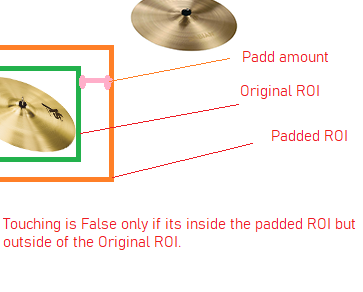

### <font style="color:rgb(134,19,348)"> Padding Function   </font>
Now below function paddings all roi's by 60, you can choose a different value for your own case, Note I've put them in the try block because for some of these ROI's which lie at the border there will be negative numbers which raises errors.

In [26]:
def padd(x,y):
    
    found = False
    padder=60
    
    try:
        for i, it in enumerate(d1):
            if y > it[0] - padder and y < it[1] +padder and x > it[2] - padder and x < it[3] +padder:
                found = True
                return found
            
        for i, it in enumerate(r1):
            if y > it[0] - padder and y < it[1] +padder and x > it[2] - padder and x < it[3] +padder:
                found = True
                return found

    except:
        pass

    return found

**Now lets see the complete program for 2 sticks**

In [80]:
useload =False
if useload:
    drumval = np.load('media/M12/drumval.npy')

cap = cv2.VideoCapture(2)
cap.set(cv2.CAP_PROP_AUTOFOCUS, 0)

cv2.namedWindow('image2', cv2.WINDOW_NORMAL)

while(True):
    ret, frame = cap.read()
    frame = cv2.flip( frame, 1 ) 
    if ret:
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # If you're reading from memory then load the upper and lower ranges from there
        if useload:
                lower_range = drumval[0]
                upper_range = drumval[1]

        # Otherwise define your own custom values for upper and lower range.
        else:             
           lower_range  = np.array([150,70,173])
           upper_range = np.array([179,189,255])

        mask = cv2.inRange(hsv, lower_range, upper_range)

        # perform the morphological operations to get rid of the noise
        mask = cv2.erode(mask,kernel,iterations = 1)
        mask = cv2.dilate(mask,kernel,iterations = 2)
        
        contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0 and cv2.contourArea(max(contours, key = cv2.contourArea)) > 450:
            
            # Sort the contours with respect to the size
            cnt = sorted(contours, key=cv2.contourArea,reverse=True)
            
            # Loop over the top 2 contours
            for c in cnt[:2]:
                x,y,w,h = cv2.boundingRect(c)

                midx = int(x+(w/2))
                midy = int(y +(h/2))
                
                #cv2.circle(frame,(midx,midy), 5, (0,255,0), -1)
                #cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

                found,index   = inside_roi(midx,midy,d1)
                if found:

                    if touching == False:
                        playsound(drumsl[index], False)
                        touching = True

                else:
                    found,index   = inside_roi(midx,midy,r1)
                    if found:
                        if touching == False:
                            playsound(ringsl[index],False)
                            touching = True

                    else:
                            # if the x,y are not in drum,ring roi then check if they are in the padded roi
                            ptest= padd(midx,midy)
                            if ptest:
                                # if they are only then make touching false
                                touching =False


        img_bg = cv2.bitwise_and(frame,frame,mask = cv2.bitwise_not(mask_background))
        img_fg = cv2.bitwise_and(resized_drum,resized_drum,mask = mask_background)
        combined = cv2.add(img_bg,img_fg)
      

    cv2.imshow('image2',combined)
    k = cv2.waitKey(1) 
    if k == ord('q'):
        break
                
cv2.destroyAllWindows()
cap.release()        

###  <font style="color:rgb(34,169,134)"> Assignment: Make a Virtual Piano</font>
Now that you have understood how to play sounds with vision and make a complete drum, so make a piano now with at least 5 sounds and either play it with sticks or some other object, you can extract roi's of piano keys from the function we used to get drum roi's.

In [ ]:
### ADD CODE HERE

